### Stock Market Predictions NVIDIA 

#### Lineal Regression

In [6]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn import metrics 
dat = yf.Ticker("NVDA")
df = yf.download(["NVDA"], period='120mo', interval='1d') # Por hora o por minuto, o por dia 
df[('Prev Close', 'NVDA')] = df[('Close', 'NVDA')].shift(1)  # Shifted by 1 to use previous day's close to predict today's
df.dropna(inplace=True)  # Remove rows with NaN values
df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Prev Close
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2025-04-10,107.570000,110.860001,99.150002,109.370003,437812400,114.330002
2025-04-11,110.930000,111.550003,107.480003,108.500000,313417300,107.570000
2025-04-14,110.709999,114.290001,109.070000,114.110001,264705000,110.930000
2025-04-15,112.199997,113.620003,110.500000,110.970001,221749000,110.709999
2025-04-16,106.000000,106.790001,104.349998,104.550003,55987631,112.199997


In [7]:
import pyodbc 


try:
    with pyodbc.connect(r'DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=stock_market;Trusted_Connection=yes;')  as conn: # Si se pierde la conexion, cierra la sesion
        cursor = conn.cursor()
        # Method 2: Using itertuples() - faster than iterrows()
        for row in df.itertuples():
            print(f"Index: {row.Index}")
            print(row)
            
            data = {
                'ticker': 'NVDA',
                'date': row.Index,
                'close': row[1],
                'high': row[2],
                'low': row[3],
                'open': row[4],
                'volume': row[5]
            }
            print(data)
            cursor.execute("""
                INSERT INTO StockPrices (Ticker, "Date", "Close", "High", "Low", "Open", Volume)
                SELECT ?, ?, ?, ?, ?, ?, ?
                WHERE NOT EXISTS (
                    SELECT 1 FROM StockPrices 
                    WHERE Ticker = ? AND Date = ?
                )
            """, 
            data['ticker'], data['date'], data['close'], data['high'],
            data['low'], data['open'], data['volume'],
            data['ticker'], data['date'])

            cursor.execute("""
            UPDATE StockPrices
            SET     
                "Close" = COALESCE("Close", ?),
                "High" = COALESCE("High", ?),
                "Low" = COALESCE("Low", ?),
                "Open" = COALESCE("Open", ?),
                "Volume" = COALESCE("Volume", ?)
            WHERE Ticker = ? AND "Date" = ?
            """, data['close'], data['high'],
            data['low'], data['open'], data['volume'], data['ticker'], data["date"])
        
            if cursor.rowcount > 0:
                print("New record inserted successfully")
            else:
                print("Record already exists - no insertion made")
            
except pyodbc.Error as e:
    print(f"Database error: {e}")

Index: 2015-04-17 00:00:00
Pandas(Index=Timestamp('2015-04-17 00:00:00'), _1=0.5348284840583801, _2=0.5401286040050998, _3=0.5302511103515909, _4=0.5304920066187981, _5=293636000, _6=0.541814923286438)
{'ticker': 'NVDA', 'date': Timestamp('2015-04-17 00:00:00'), 'close': 0.5348284840583801, 'high': 0.5401286040050998, 'low': 0.5302511103515909, 'open': 0.5304920066187981, 'volume': 293636000}
New record inserted successfully
Index: 2015-04-20 00:00:00
Pandas(Index=Timestamp('2015-04-20 00:00:00'), _1=0.5321784019470215, _2=0.5406103448765697, _3=0.5312147020936703, _4=0.5372375677047504, _5=231624000, _6=0.5348284840583801)
{'ticker': 'NVDA', 'date': Timestamp('2015-04-20 00:00:00'), 'close': 0.5321784019470215, 'high': 0.5406103448765697, 'low': 0.5312147020936703, 'open': 0.5372375677047504, 'volume': 231624000}
New record inserted successfully
Index: 2015-04-21 00:00:00
Pandas(Index=Timestamp('2015-04-21 00:00:00'), _1=0.5314556360244751, _2=0.538683040026181, _3=0.5288055476837055,

In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Fetch historical data
def get_stock_data():
    ticker = "NVDA"
    df = yf.download(ticker, period='120mo', interval='1d')
    df = df[['Close']].copy()
    df.columns = ['close']
    
    # Create features
    df['prev_close'] = df['close'].shift(1)
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_10'] = df['close'].rolling(window=10).mean()
    df['daily_return'] = df['close'].pct_change()
    df.dropna(inplace=True)
    return df

# Prepare data for modeling
def prepare_data(df):
    # Create target (next day's closing price)
    df['target'] = df['close'].shift(-1)
    df.dropna(inplace=True)
    
    X = df.drop(['target'], axis=1)
    y = df['target']
    
    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, shuffle=False)
    
    return X_train, X_test, y_train, y_test, scaler, X, y

# Train models and evaluate
def train_and_evaluate(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'r2_score': r2,
            'predictions': y_pred
        }
        print(f"{name} R-squared: {r2:.4f}")
    
    return results

# Make prediction for tomorrow
def predict_tomorrow(models, df, scaler):
    # Prepare most recent data point
    last_data = df.iloc[-1:].drop(['target'], axis=1)
    last_data_scaled = scaler.transform(last_data)
    
    predictions = {}
    tomorrow_date = (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')
    
    for name, result in models.items():
        pred_price = result['model'].predict(last_data_scaled)[0]
        predictions[name] = {
            'date': tomorrow_date,
            'predicted_price': round(pred_price, 2),
            'model': name,
            'r2_score': result['r2_score']
        }
    
    return pd.DataFrame.from_dict(predictions, orient='index')

# Main execution
if __name__ == "__main__":
    # Get and prepare data
    df = get_stock_data()
    X_train, X_test, y_train, y_test, scaler, X, y = prepare_data(df)
    
    # Train and evaluate models
    model_results = train_and_evaluate(X_train, X_test, y_train, y_test)
    
    # Make tomorrow's prediction
    tomorrow_pred = predict_tomorrow(model_results, df, scaler)
    print("\nTomorrow's Predictions:")
    print(tomorrow_pred[['date', 'predicted_price', 'r2_score']])
    
    # Save predictions to database (using your existing code)
    try:
        with pyodbc.connect(r'DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=stock_market;Trusted_Connection=yes;') as conn:
            cursor = conn.cursor()
            
            for index, row in tomorrow_pred.iterrows():
                cursor.execute("""
                    INSERT INTO StockPredictions (Ticker, Date, Model, PredictedPrice, R2Score)
                    VALUES (?, ?, ?, ?, ?)
                """, 'NVDA', row['date'], row['model'], row['predicted_price'], row['r2_score'])
                
            conn.commit()
            print("Predictions saved to database successfully")
            
    except pyodbc.Error as e:
        print(f"Database error: {e}")

[*********************100%***********************]  1 of 1 completed


Linear Regression R-squared: 0.9924
Random Forest R-squared: -2.0373
XGBoost R-squared: -2.0463

Tomorrow's Predictions:
                         date  predicted_price  r2_score
Linear Regression  2025-04-17       112.800000  0.992387
Random Forest      2025-04-17        31.170000 -2.037299
XGBoost            2025-04-17        30.790001 -2.046335
Predictions saved to database successfully


[*********************100%***********************]  1 of 1 completed


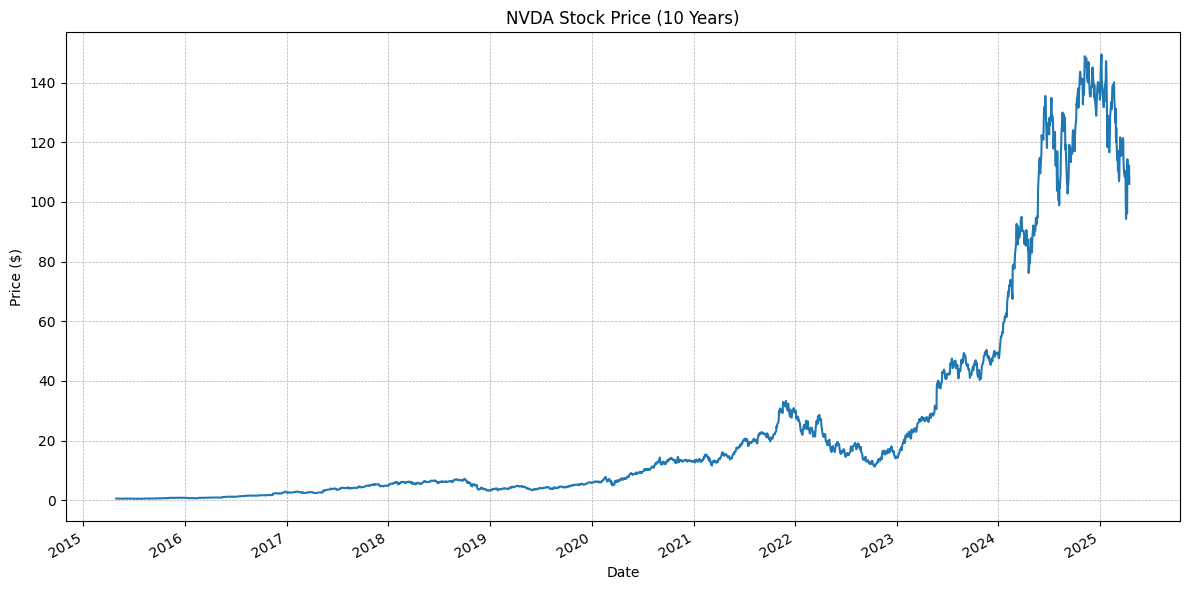

Linear Regression R-squared: 0.9924
Random Forest R-squared: -2.0377
XGBoost R-squared: -2.0463

Tomorrow's Predictions:
                         date  predicted_price  r2_score
Linear Regression  2025-04-17       112.800000  0.992388
Random Forest      2025-04-17        31.160000 -2.037697
XGBoost            2025-04-17        30.790001 -2.046338
Predictions saved to database successfully


In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pyodbc

# Fetch historical data
def get_stock_data():
    ticker = "NVDA"
    df = yf.download(ticker, period='120mo', interval='1d')
    df = df[['Close']].copy()
    df.columns = ['close']
    
    # Create features
    df['prev_close'] = df['close'].shift(1)
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_10'] = df['close'].rolling(window=10).mean()
    df['daily_return'] = df['close'].pct_change()
    df.dropna(inplace=True)
    return df

# Prepare data for modeling
def prepare_data(df):
    # Create target (next day's closing price)
    df['target'] = df['close'].shift(-1)
    df.dropna(inplace=True)
    
    X = df.drop(['target'], axis=1)
    y = df['target']
    
    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, shuffle=False)
    
    return X_train, X_test, y_train, y_test, scaler, X, y

# Train models and evaluate
def train_and_evaluate(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'r2_score': r2,
            'predictions': y_pred
        }
        print(f"{name} R-squared: {r2:.4f}")
    
    return results

# Make prediction for tomorrow
def predict_tomorrow(models, df, scaler):
    # Prepare most recent data point
    last_data = df.iloc[-1:].drop(['target'], axis=1)
    last_data_scaled = scaler.transform(last_data)
    
    predictions = {}
    tomorrow_date = (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')
    
    for name, result in models.items():
        pred_price = result['model'].predict(last_data_scaled)[0]
        predictions[name] = {
            'date': tomorrow_date,
            'predicted_price': round(pred_price, 2),
            'model': name,
            'r2_score': result['r2_score']
        }
    
    return pd.DataFrame.from_dict(predictions, orient='index')

# Plot stock price history
def plot_stock_price(df):
    plt.figure(figsize=(12, 6))
    df['close'].plot()
    plt.title("NVDA Stock Price (10 Years)")
    plt.ylabel("Price ($)")
    plt.xlabel("Date")
    plt.grid(which="major", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Get and prepare data
    df = get_stock_data()
    
    # Plot historical prices
    plot_stock_price(df)
    
    X_train, X_test, y_train, y_test, scaler, X, y = prepare_data(df)
    
    # Train and evaluate models
    model_results = train_and_evaluate(X_train, X_test, y_train, y_test)
    
    # Make tomorrow's prediction
    tomorrow_pred = predict_tomorrow(model_results, df, scaler)
    print("\nTomorrow's Predictions:")
    print(tomorrow_pred[['date', 'predicted_price', 'r2_score']])
    
    # Save predictions to database
    try:
        with pyodbc.connect(r'DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=stock_market;Trusted_Connection=yes;') as conn:
            cursor = conn.cursor()
            
            for index, row in tomorrow_pred.iterrows():
                cursor.execute("""
                    INSERT INTO StockPredictions (Ticker, Date, Model, PredictedPrice, R2Score)
                    VALUES (?, ?, ?, ?, ?)
                """, 'NVDA', row['date'], row['model'], row['predicted_price'], row['r2_score'])
                
            conn.commit()
            print("Predictions saved to database successfully")
            
    except pyodbc.Error as e:
        print(f"Database error: {e}")

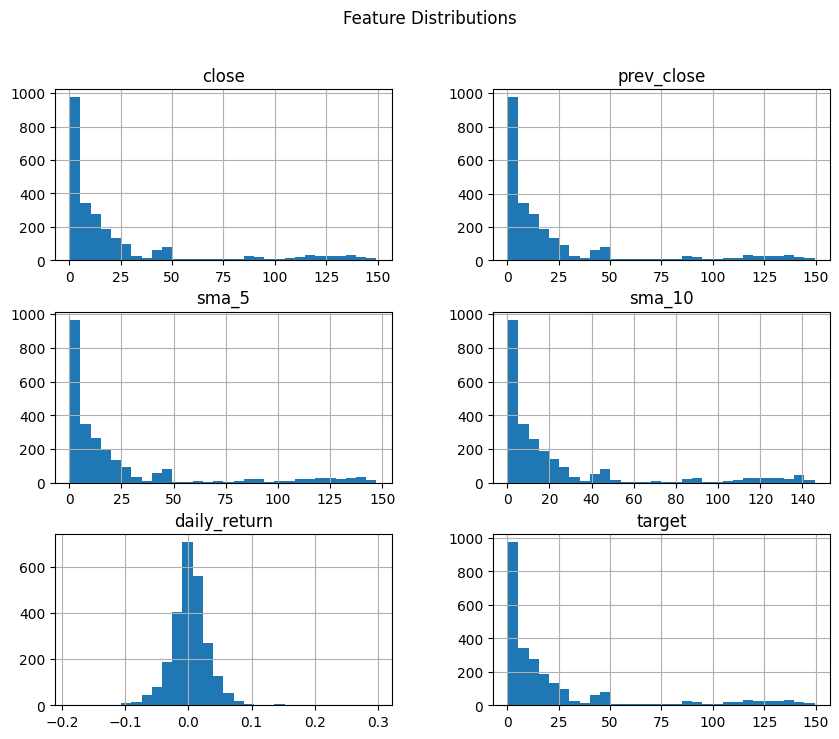

In [10]:
df.hist(figsize=(10, 8), bins=30)
plt.suptitle("Feature Distributions")
plt.show()